# Preparation

## Install Requirement

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1
!pip install -qU watermark

## Custom Matplotlib Style

In [0]:
mpl_style = "https://gist.githubusercontent.com/m3hrdadfi/af8aca01094afb7d3e5b46de9ad8d509/raw/871ec5d721a3b438c3c896718ea4aafc91ea9744/gadfly.mplstyle"
!wget -q $mpl_style -O /root/.config/matplotlib/matplotlibrc

## General Paramas

A random seed is a number used to initialize a pseudorandom number generator. For a seed to be used in a pseudorandom number generator, it does not need to be random

In [0]:
RANDOM_SEED = 141

## Import requried packages

In [0]:
import tensorflow as tf

import requests
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

import cv2

from sklearn.utils import shuffle

import random
import sys
import io
import re
import time
from datetime import datetime
import os
import struct
from tqdm import tqdm

from pprint import pprint


%matplotlib inline
mpl.rc_file(mpl.matplotlib_fname())

# Persian MNIST

Data Set Information:


Attribute Information:
1. pixels
2. class: 
    - 0
    - 1
    - 2
    - 3
    - 4
    - 5
    - 6
    - 7
    - 8
    - 9

In [0]:
!wget https://www.dropbox.com/s/op3ht07lfou9lbz/DigitDB.zip
!unzip DigitDB.zip
!ls 

--2019-07-23 09:59:46--  https://www.dropbox.com/s/op3ht07lfou9lbz/DigitDB.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/op3ht07lfou9lbz/DigitDB.zip [following]
--2019-07-23 09:59:46--  https://www.dropbox.com/s/raw/op3ht07lfou9lbz/DigitDB.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc83511e18f0438b066dc0e4fa81.dl.dropboxusercontent.com/cd/0/inline/AlPUbcmsENel95x_YhWnlxSWbaiWs7ZpEmMak5aL6ZcKo2jkmy7Gf6haODyFRw8ZHQv6wA3fnYJbLIK_m2wo361VIyNd48-MsZsJw3DE3Y-uEg/file# [following]
--2019-07-23 09:59:47--  https://uc83511e18f0438b066dc0e4fa81.dl.dropboxusercontent.com/cd/0/inline/AlPUbcmsENel95x_YhWnlxSWbaiWs7ZpEmMak5aL6ZcKo2jkmy7Gf6haODyFRw8ZHQv6wA3fnYJbLIK_m2wo361VIyNd48-MsZsJw3DE3Y-uEg/file
Resolving uc83511e18f0

In [0]:
def resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset + img_height, x_offset:x_offset + img_width] = img

    return dst_image


def read_cdb(filepath):
    with open(filepath, 'rb') as f:
        data = f.read()
        offset = 0

        # read private header
        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        h = struct.unpack_from('B', data, offset)[0]
        offset += 1

        w = struct.unpack_from('B', data, offset)[0]
        offset += 1

        total_rec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        letter_count = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        img_type = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (w > 0) and (h > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in tqdm(range(total_rec), position=0):

            start_byte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                w = struct.unpack_from('B', data, offset)[0]
                offset += 1

                h = struct.unpack_from('B', data, offset)[0]
                offset += 1

            byte_count = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[h, w], dtype=np.uint8)

            if img_type == 0:
                # Binary
                for y in range(h):
                    b_white = True
                    counter = 0
                    while counter < w:
                        wb_count = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        
                        if b_white:
                            image[y, counter:counter + wb_count] = 0  # Background
                        else:
                            image[y, counter:counter + wb_count] = 255  # ForeGround
                        b_white = not b_white  # black white black white ...
                        counter += wb_count
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(w * h), data, offset)
                offset += w * h
                image = np.asarray(data, dtype=np.uint8).reshape([w, h]).T

            images.append(image)
            labels.append(label)

        return images, labels
    

def load_data(datapath, img_height=32, img_width=32):
    images, labels = read_cdb(datapath)
    assert len(images) == len(labels)
    
    x = np.zeros(shape=[len(images), img_height, img_width], dtype=np.float32)
    y = np.zeros(shape=[len(labels)], dtype=np.int)
    
    for i in tqdm(range(len(images)), position=0):
        image = images[i]
        image = resize_image(src_image=image, dst_image_height=img_height, dst_image_width=img_width)
        image = image / 255
        image = np.where(image >= 0.5, 1, 0)
        
        x[i] = image
        y[i] = labels[i]
    
    x, y = shuffle(x, y, random_state=0)
    
    return x, y

# Load the data

In [0]:
trainset_dir = 'Train 60000.cdb'
testset_dir = 'Test 20000.cdb'

x_train, y_train = load_data(trainset_dir)
x_test, y_test = load_data(testset_dir)

print('Train: %s, Labels: #%s' %(x_train.shape, len(y_train)))
print('Test: %s, Labels: #%s' %(x_test.shape, len(y_test)))

100%|██████████| 20000/20000 [00:00<00:00, 54550.40it/s]


Train: (60000, 32, 32), Labels: #60000
Test: (20000, 32, 32), Labels: #20000


# Visualize the data

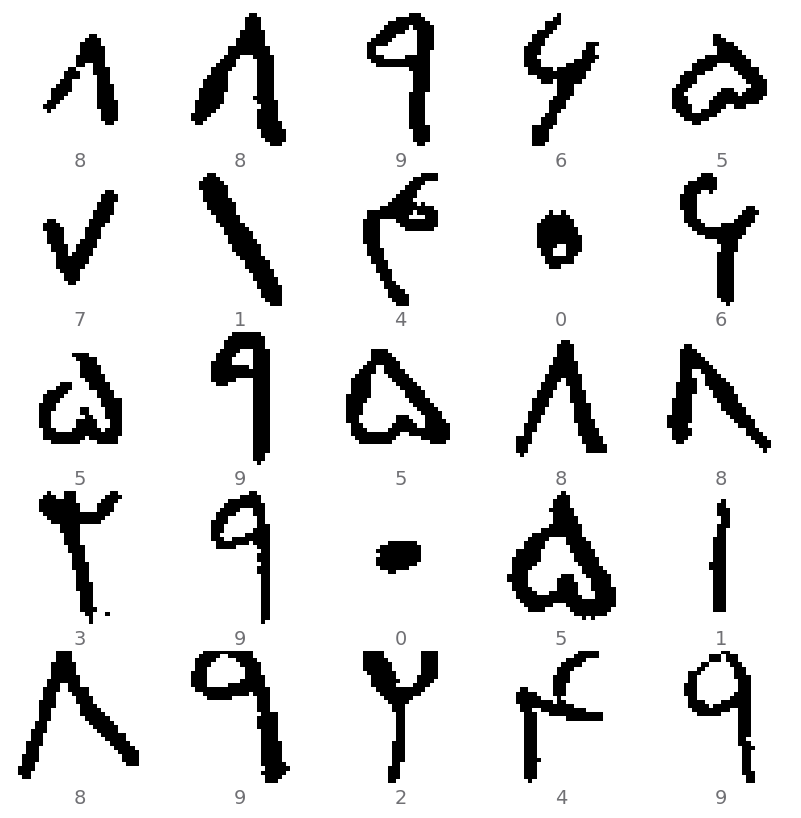

In [0]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(str(y_train[i]))
plt.show()

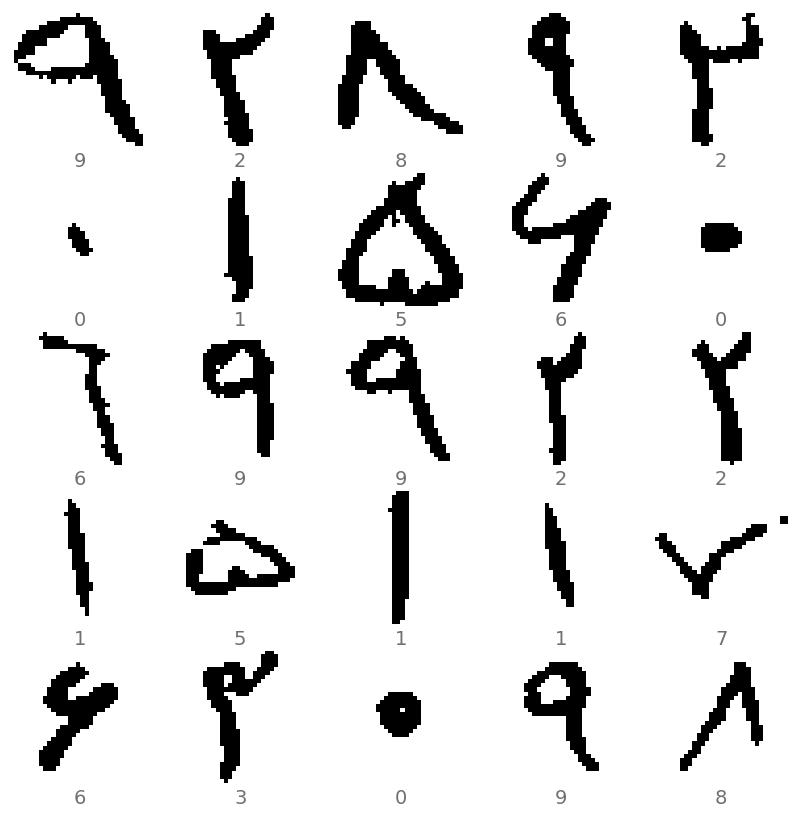

In [0]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(str(y_test[i]))
plt.show()

# Preprocessing

In [0]:
# 

# Configure Neural Network Models

## Create non-linear model

## Summary of the model

## Plotting

## Evaluation

In [0]:

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(str(predicted_label),
                                         100 * np.max(predictions_array),
                                         str(true_label)), color=color)


def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')